# Use long-short term memory networks to forecast carbon intensity #

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Function for LSTM data processing ##

In [ ]:
def create_lstm_sequences(data, lookback_window=12):
    """
    Function processes a dataframe for LSTM input
    """
    X, Y = [], []
    # 'data' here is the NumPy array 'scaled_data'
    
    # This line is correct only if 'data' is a NumPy array (which scaled_data is)
    data_1d = data.flatten() 
    
    for i in range(len(data_1d) - lookback_window):
        X.append(data_1d[i:(i + lookback_window)])
        Y.append(data_1d[i + lookback_window])
        
    return np.array(X), np.array(Y)

## Preprocess data for monthly sampling ##

In [ ]:
# import dataset
df = pd.read_csv('../data/df_fuel_ckan.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df_filtered = df[df['DATETIME'].dt.year < 2025].copy()
df_filtered.set_index('DATETIME', inplace=True)
data_train_test = df_filtered['CARBON_INTENSITY'].resample('ME').mean().dropna()

scaler = MinMaxScaler(feature_range=(0, 1))

# Normalising the data for better convergence
# Reshape the data for the scaler: (n_samples, 1) is required
data_for_scaling = data_train_test.values.reshape(-1, 1)

# Fit the scaler on the data and transform it
scaled_data = scaler.fit_transform(data_for_scaling)

X_sequenced, Y_targets = create_lstm_sequences(scaled_data, lookback_window=12)
print(f"Sequenced X shape before reshape: {X_sequenced.shape}")

split_point = int(len(X_sequenced) * 0.8)
# Chronological Split
X_train, X_test = X_sequenced[:split_point], X_sequenced[split_point:]
y_train, y_test = Y_targets[:split_point], Y_targets[split_point:]

# RESHAPE FOR LSTM
# Required shape: (n_samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Reshape Y targets to (n_samples, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

Sequenced X shape before reshape: (180, 12)


## Define LSTM model ##

In [56]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


c:\Users\tianw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train the model ##

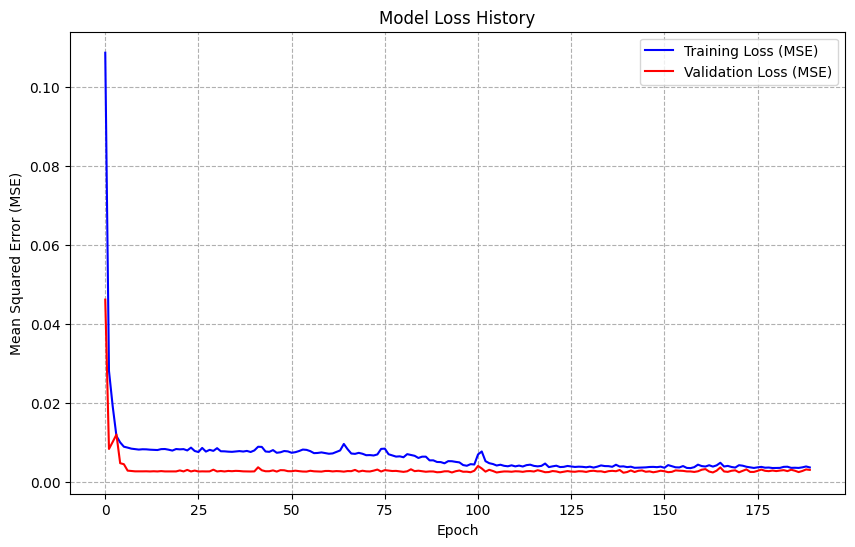

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,         
    restore_best_weights=True
)

history = model.fit(X_train, y_train, 
                    epochs=1000, 
                    batch_size=16, 
                    verbose=0,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping]
                    )

plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss (MSE)', color='blue')

# Plot validation loss 
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', color='red')
    
plt.title('Model Loss History')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--')
plt.show()

## plotting the forecast and real curve ##

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


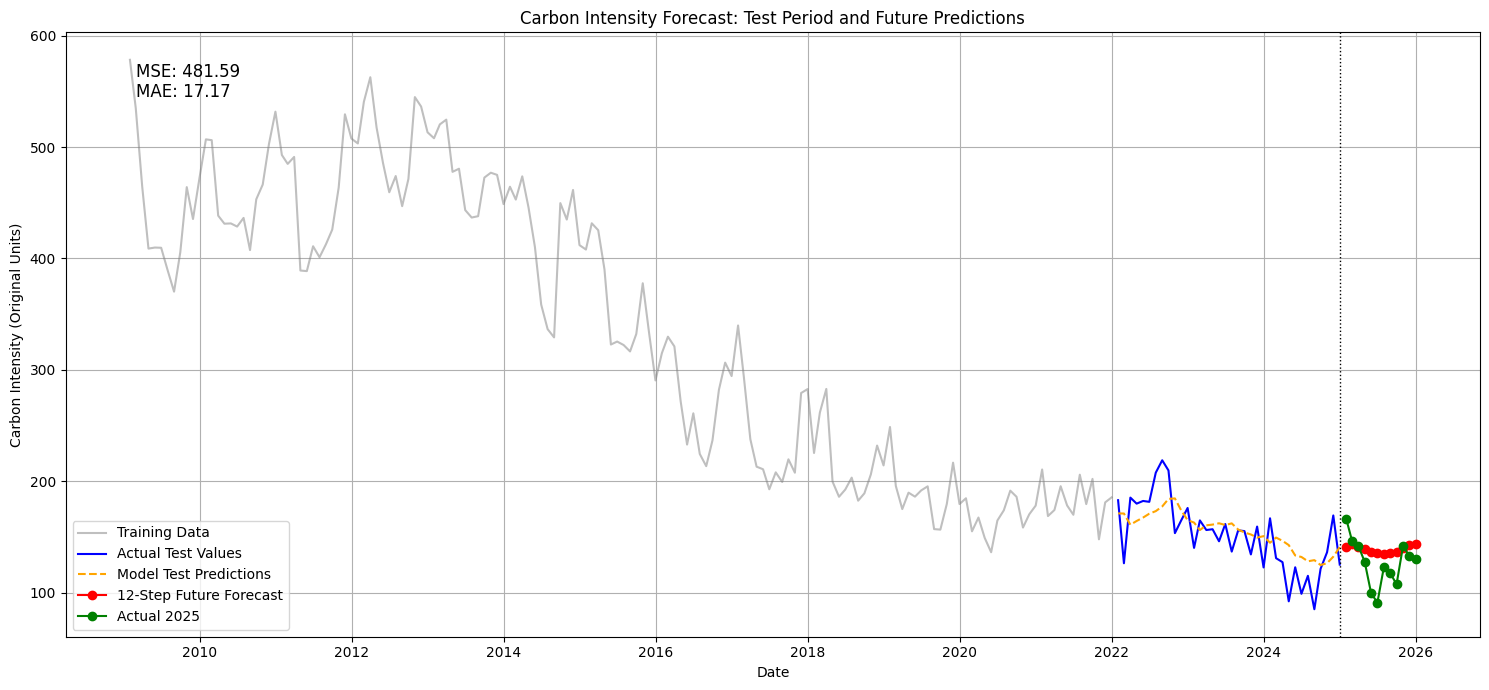

In [ ]:
# Get the last input sequence from the test set
# Shape of last_sequence_scaled: (1, timesteps, 1)
last_sequence_scaled = X_test[-1].copy()
last_sequence_scaled = last_sequence_scaled.reshape(1, X_test.shape[1], 1)

# Initialize a list to hold the future forecasts (scaled)
future_forecasts_scaled = []
n_future_steps = 12 # Number of steps to predict

# --- 2. Recursive Prediction Loop ---

for i in range(n_future_steps):
    # a. Predict the next step
    # prediction shape is (1, 1), scaled
    next_step_pred_scaled = model.predict(last_sequence_scaled, verbose=0)
    
    # b. Store the prediction
    future_forecasts_scaled.append(next_step_pred_scaled[0, 0])
    
    # c. Prepare the new sequence for the next prediction
    # This involves shifting the sequence (removing the first element and adding the new prediction)
    
    # Get the sequence array (dropping the batch dimension)
    current_sequence = last_sequence_scaled[0] 
    
    # Remove the first element (the oldest observation)
    new_sequence = np.delete(current_sequence, 0, axis=0)
    
    # Append the new prediction (reshaped to fit the sequence feature dimension)
    new_sequence = np.append(new_sequence, next_step_pred_scaled.reshape(1, 1), axis=0)
    
    # Update the sequence for the next loop iteration (add batch dimension back)
    last_sequence_scaled = new_sequence.reshape(1, X_test.shape[1], 1)

# Convert the list of scaled predictions into a 2D array
future_forecasts_scaled_array = np.array(future_forecasts_scaled).reshape(-1, 1)

# Inverse transform to get forecasts in original units
future_forecasts_actual = scaler.inverse_transform(future_forecasts_scaled_array)

y_test_actual = scaler.inverse_transform(y_test)
test_predictions_scaled = model.predict(X_test)
test_predictions_actual = scaler.inverse_transform(test_predictions_scaled)

# b. Create Future Dates
# Get the last date from the original monthly data
last_date = data_train_test.index[-1]
# Generate the next 12 month-end dates
future_dates = pd.date_range(start=last_date, periods=n_future_steps + 1, freq='ME')[1:] 


# Combine all series into a DataFrame for easy plotting alignment
forecast_df = pd.DataFrame({
    'Actual_Test': y_test_actual.flatten(),
    'Predicted_Test': test_predictions_actual.flatten()
}, index=data_train_test.index[-len(y_test_actual):])

# Append future forecasts
future_series = pd.Series(future_forecasts_actual.flatten(), index=future_dates)

# Data points of 2025
df_2025 = df[df['DATETIME'].dt.year == 2025].copy()
df_2025.set_index('DATETIME', inplace=True)
# Handle resampling compatibility
try:
    actual_2025 = df_2025['CARBON_INTENSITY'].resample('ME').mean().dropna()
except ValueError:
    actual_2025 = df_2025['CARBON_INTENSITY'].resample('M').mean().dropna()
MSE = mean_squared_error(actual_2025, future_series)
MAE = mean_absolute_error(actual_2025, future_series)

# Create the plot
plt.figure(figsize=(15, 7))

# Plot the end of the training data (for context)
plt.plot(data_train_test.index[:-len(y_test)], data_train_test.values[:-len(y_test)], 
         label='Training Data', color='gray', alpha=0.5)

# Plot the test data (Actual vs. Predicted)
plt.plot(forecast_df.index, forecast_df['Actual_Test'], label='Actual Test Values', color='blue')
plt.plot(forecast_df.index, forecast_df['Predicted_Test'], label='Model Test Predictions', color='orange', linestyle='--')

# Plot the future forecasts
plt.plot(future_series.index, future_series.values, label=f'{n_future_steps}-Step Future Forecast', 
         color='red', marker='o', linestyle='-')
plt.plot(actual_2025.index, actual_2025, label='Actual 2025', color='green', marker='o')
# Add a vertical line where the test data ends
plt.axvline(x=forecast_df.index[-1], color='black', linestyle=':', linewidth=1)

plt.title('Carbon Intensity Forecast: Test Period and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Carbon Intensity (Original Units)')
plt.text(0.05, 0.95, f'MSE: {MSE:.2f}\nMAE: {MAE:.2f}', transform=plt.gca().transAxes, va='top', ha='left', fontsize=12)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()